In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
rootDir_I = 'L:/DATA/Alouette_I/BATCH_I_Run2/'
resultDir_I = rootDir_I + '05_result/'
logDir_I = rootDir_I + '06_log/'

In [3]:
rootDir_II = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
resultDir_II = rootDir_II + '05_result/'
logDir_II = rootDir_II + '06_log/'

In [4]:
rootDir_tot = 'L:/DATA/Alouette_I/Total/'
resultDir_tot = rootDir_tot + '05_result/'
logDir_tot = rootDir_tot + '06_log/'

## Num Category

In [5]:
#Total Number of Num Categories
df_I = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_I = df_I[df_I['processed_image_class']=='num']
total_df_I = len(filter_df_I)
print ('Total number of NUM Ionograms in Batch I:', total_df_I)

df_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_II = df_II[df_II['processed_image_class']=='num']
total_df_II = len(filter_df_II)
print ('Total number of NUM Ionograms in Batch II :', total_df_II)

Total_num = total_df_I + total_df_II #combining Batch I and Batch II num data
print ('Total number of NUM Ionograms in both batches:', Total_num)

Total number of NUM Ionograms in Batch I: 465009
Total number of NUM Ionograms in Batch II : 114045
Total number of NUM Ionograms in both batches: 579054


### Batch I

Number of Images Analyzed in BATCH I: 49
Number of "year" element categorized correctly: 48
Percent reading accuracy of the "year" element: 97.96%
Sample Error for "year" element: 2.02
Number of "Day_1" element categorized correctly: 48
Percent reading accuracy of the "Day_1" element: 97.96%
Sample Error for "Day_1" element: 2.02
Number of "Day_2" element categorized correctly: 48
Percent reading accuracy of the "Day_2" element: 97.96%
Sample Error for "Day_2" element: 2.02
Number of "Day_3" element categorized correctly: 48
Percent reading accuracy of the "Day_3" element: 97.96%
Sample Error for "Day_3" element: 2.02
Number of "Hour_1" element categorized correctly: 48
Percent reading accuracy of the "Hour_1" element: 97.96%
Sample Error for "Hour_1" element: 2.02
Number of "Hour_2" element categorized correctly: 48
Percent reading accuracy of the "Hour_2" element: 97.96%
Sample Error for "Hour_2" element: 2.02
Number of "Min_1" element categorized correctly: 48
Percent reading accura

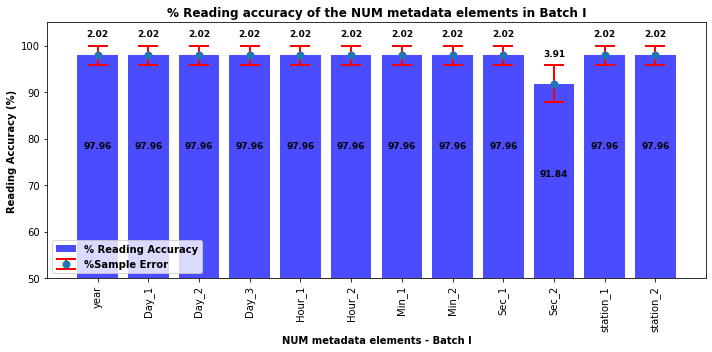

In [81]:
df_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_QA.csv") 
total_I = len(df_I)
print ('Number of Images Analyzed in BATCH I:', total_I)

categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data_I = []
for column in categorical_columns:
    col_sum = df_I[column].sum()
    accuracy_percent = (col_sum/total_I)*100
    p = accuracy_percent/100
    sample_error = np.sqrt(p*(1-p)/total_I)*100
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: {accuracy_percent:.2f}%')
    print (f'Sample Error for "{column}" element: {sample_error:.2f}')
    
    accuracy_data_I.append ((column, accuracy_percent,sample_error))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies,sample_error  = zip(*accuracy_data_I) 
bar = plt.bar (categories, accuracies, color = 'blue', alpha = 0.7)
error_bar = plt.errorbar(categories, accuracies, yerr = sample_error,fmt= 'o', capsize = 10, ecolor = 'red', elinewidth = 2, markeredgewidth = 2)
plt.ylim(50, 105)

plt.title ("% Reading accuracy of the NUM metadata elements in Batch I", fontweight = 'bold')
plt.xlabel("NUM metadata elements - Batch I", fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)", fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks (np.arange(50, 105, step = 10))
#creating a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', '%Sample Error']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding numbers on top of the error bars and bars
for i, (bar_height, err_height) in enumerate (zip(accuracies, sample_error)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plt.text(i, bar_height + -20 , f'{bar_height:.2f}', ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
    plt.text(i, bar_height + err_height+2, f'{err_height:.2f}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.tight_layout()
plt.show()

In [82]:
# BATCH I - Summary
df_I = df_I.loc[df_I['Issue'] != 'None'] 
filtered_down_I = len(df_I)
print('Number of Ionograms categorized correctly consistently:', total_I - filtered_down_I)

#BATCH I - Estimated success rate Batch I
success_rate = (total_I - filtered_down_I)/total_I 
Estimation = round(success_rate*total_df_I)
print('Estimated Success Rate out of BATCH I with 465,009 ionograms:', Estimation)

# Number of All categories error
df_I = df_I.loc[df_I['Issue'] == 'All categories']
filtered_down_I = len(df_I)
print('Number of incorrectly analyzed ionograms across all categories:', filtered_down_I)
print(df_I.loc[:,["Directory","Subdirectory", "filename"]])

Number of Ionograms categorized correctly consistently: 45
Estimated Success Rate out of BATCH I with 465,009 ionograms: 427049
Number of incorrectly analyzed ionograms across all categories: 1
     Directory Subdirectory       filename
3  R014207909F          713  Image0317.png


### Batch II

Number of Images Analyzed in BATCH II: 50
Number of "year" element categorized correctly: 45
Percent reading accuracy of the "year" element: 90.00%
Sample Error for "year" element: 4.24
Number of "Day_1" element categorized correctly: 46
Percent reading accuracy of the "Day_1" element: 92.00%
Sample Error for "Day_1" element: 3.84
Number of "Day_2" element categorized correctly: 46
Percent reading accuracy of the "Day_2" element: 92.00%
Sample Error for "Day_2" element: 3.84
Number of "Day_3" element categorized correctly: 45
Percent reading accuracy of the "Day_3" element: 90.00%
Sample Error for "Day_3" element: 4.24
Number of "Hour_1" element categorized correctly: 45
Percent reading accuracy of the "Hour_1" element: 90.00%
Sample Error for "Hour_1" element: 4.24
Number of "Hour_2" element categorized correctly: 45
Percent reading accuracy of the "Hour_2" element: 90.00%
Sample Error for "Hour_2" element: 4.24
Number of "Min_1" element categorized correctly: 46
Percent reading accur

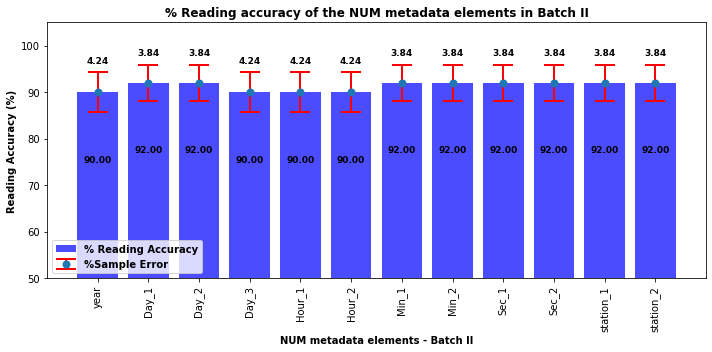

In [83]:
df_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num.csv") 
total_II = len(df_II)
print ('Number of Images Analyzed in BATCH II:', total_II)

categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data_II= []
for column in categorical_columns:
    col_sum = df_II[column].sum()
    accuracy_percent = (col_sum/total_II)*100
    p = accuracy_percent/100
    sample_error = np.sqrt(p*(1-p)/total_II)*100
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: {accuracy_percent:.2f}%')
    print (f'Sample Error for "{column}" element: {sample_error:.2f}')
    
    accuracy_data_II.append ((column, accuracy_percent,sample_error))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies, sample_error  = zip(*accuracy_data_II) 
bar = plt.bar (categories, accuracies, color = 'blue', alpha = 0.7)
error_bar = plt.errorbar(categories, accuracies, yerr = sample_error,fmt= 'o', capsize = 10, ecolor = 'red', elinewidth = 2, markeredgewidth = 2)
plt.ylim(50, 105)

plt.title ("% Reading accuracy of the NUM metadata elements in Batch II", fontweight = 'bold')
plt.xlabel("NUM metadata elements - Batch II", fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)", fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks (np.arange(50, 105, step = 10))
#creating a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', '%Sample Error']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding numbers on top of the error bars and bars
for i, (bar_height, err_height) in enumerate (zip(accuracies, sample_error)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plt.text(i, bar_height + -15 , f'{bar_height:.2f}', ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
    plt.text(i, bar_height + err_height+2, f'{err_height:.2f}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.tight_layout()
plt.show()


In [84]:
# BATCH II - Summary
df_II = df_II.loc[df_II['Issue'] != 'None']
filtered_down_II = len(df_II)
print ('Batch II Summary:')
print('Total number of Ionograms categorized correctly consistently:', total_II - filtered_down_II)

#BATCH II - Estimated success rate
success_rate = (total_II - filtered_down_II)/total_II
Estimation = round(success_rate*total_df_II)
print('Estimated Success Rate of BATCH II with 123,975 ionograms:', Estimation)

# Number of All categories error
df_II = df_II.loc[df_II['Issue'] == 'All category']
filtered_down_II = len(df_II)
print('The "All Category" error is due to the number of NUM2 ionograms incorrectly categorized as Num data by the algorithm:', filtered_down_II)
print(df_II.loc[:,["Directory","Subdirectory", "filename"]])

Batch II Summary:
Total number of Ionograms categorized correctly consistently: 45
Estimated Success Rate of BATCH II with 123,975 ionograms: 102640
The "All Category" error is due to the number of NUM2 ionograms incorrectly categorized as Num data by the algorithm: 4
     Directory Subdirectory filename
11  R014207820      2979-5B  109.png
16  R014207825     3729-19A  105.png
44  R014207808      4575-50   14.png
49  R014207819      4757-15   77.png


### Total NUM category analysis

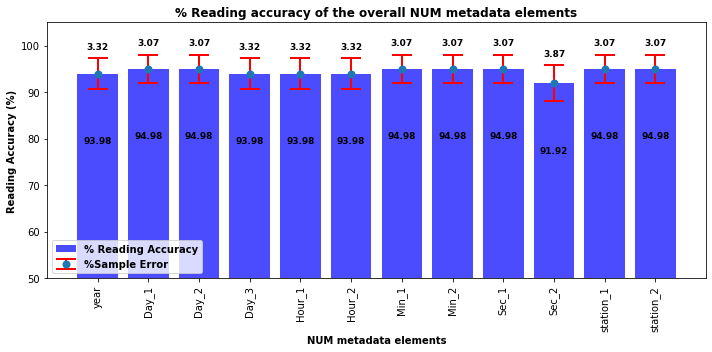

In [85]:
combined_accuracy_data = []
for i in range(len(categorical_columns)):
    column = categorical_columns [i]
    combined_accuracy =(accuracy_data_I[i][1] + accuracy_data_II[i][1])/2
    combined_sample_error = np.sqrt((accuracy_data_I[i][2]**2 + accuracy_data_II[i][2]**2)/2)
    combined_accuracy_data.append((column, combined_accuracy, combined_sample_error))
    
#plotting the graph of batch I and II
fig = plt.figure (figsize= (10, 5))
categories, accuracies, sample_error = zip(*combined_accuracy_data)
bar = plt.bar(categories, accuracies, color = 'blue', alpha = 0.7)
error_bar = plt.errorbar(categories, accuracies, yerr = sample_error, fmt="o", capsize = 10,
                        ecolor = 'red', elinewidth = 2, markeredgewidth = 2)

plt.ylim(50, 105)
plt.title ("% Reading accuracy of the overall NUM metadata elements", fontweight = 'bold')
plt.xlabel("NUM metadata elements",  fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)",  fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks(np.arange(50, 105, step = 10))

#adding a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', '%Sample Error']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding numbers on top of the error bars and bars
for i, (bar_height, err_height) in enumerate (zip(accuracies, sample_error)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plt.text(i, bar_height + -15 , f'{bar_height:.2f}', ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
    plt.text(i, bar_height + err_height+2, f'{err_height:.2f}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.tight_layout()
plt.show()
                                                                  

## NUM2 category

In [20]:
#Total Number of Num Categories
df_num2_1 = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_num2_1 = df_num2_1[df_num2_1['processed_image_class']=='num2']
total_df_num2_1 = len(filter_df_num2_1)
print ('Total number of NUM2 Ionograms in Batch I:', total_df_num2_1)

df_num2_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_num2_II = df_num2_II[df_num2_II['processed_image_class']=='num2']
total_df_num2_II = len(filter_df_num2_II)
print ('Total number of NUM2 Ionograms in Batch II :', total_df_num2_II)

df_num2_total = pd.read_csv(resultDir_tot + 'result_master.csv')
filter_df_total= df_num2_total[df_num2_total['processed_image_class']=='num2']
total_df_num2 = len(filter_df_total)
print('Total number of NUM2 Ionograms in both batches:', total_df_num2)

Total number of NUM2 Ionograms in Batch I: 38149
Total number of NUM2 Ionograms in Batch II : 87924
Total number of NUM2 Ionograms in both batches: 126073


### Batch I

Number of Images Analyzed in BATCH I: 15
Number of "year" element categorized correctly: 15
Percent reading accuracy of the "year" element: 100.00%
Sample Error for "year" element: 0.00
Number of "Day_1" element categorized correctly: 15
Percent reading accuracy of the "Day_1" element: 100.00%
Sample Error for "Day_1" element: 0.00
Number of "Day_2" element categorized correctly: 11
Percent reading accuracy of the "Day_2" element: 73.33%
Sample Error for "Day_2" element: 11.42
Number of "Day_3" element categorized correctly: 10
Percent reading accuracy of the "Day_3" element: 66.67%
Sample Error for "Day_3" element: 12.17
Number of "Hour_1" element categorized correctly: 14
Percent reading accuracy of the "Hour_1" element: 93.33%
Sample Error for "Hour_1" element: 6.44
Number of "Hour_2" element categorized correctly: 13
Percent reading accuracy of the "Hour_2" element: 86.67%
Sample Error for "Hour_2" element: 8.78
Number of "Min_1" element categorized correctly: 14
Percent reading ac

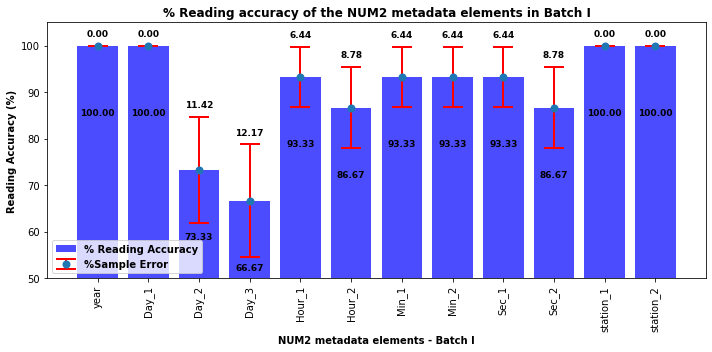

In [89]:
df_num2_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_num2_QA.csv") 
total_num2_I = len(df_num2_I)
print ('Number of Images Analyzed in BATCH I:', total_num2_I)
categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data_num2_I = []
for column in categorical_columns:
    col_sum = df_num2_I[column].sum()
    accuracy_percent = (col_sum/total_num2_I)*100
    p = accuracy_percent/100
    sample_error = np.sqrt(p*(1-p)/total_num2_I)*100
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: {accuracy_percent:.2f}%')
    print (f'Sample Error for "{column}" element: {sample_error:.2f}')
    
    accuracy_data_num2_I.append ((column, accuracy_percent,sample_error))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies, sample_error  = zip(*accuracy_data_num2_I) 
bar = plt.bar (categories, accuracies, color = 'blue', alpha = 0.7)
error_bar = plt.errorbar(categories, accuracies, yerr = sample_error,fmt= 'o', capsize = 10, ecolor = 'red', elinewidth = 2, markeredgewidth = 2)
plt.ylim(50, 105)

plt.title ("% Reading accuracy of the NUM2 metadata elements in Batch I", fontweight = 'bold')
plt.xlabel("NUM2 metadata elements - Batch I", fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)", fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks (np.arange(50, 105, step = 10))

#creating a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', '%Sample Error']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding numbers on top of the error bars and bars
for i, (bar_height, err_height) in enumerate (zip(accuracies, sample_error)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plt.text(i, bar_height -15 , f'{bar_height:.2f}', ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
    plt.text(i, bar_height + err_height +2 , f'{err_height:.2f}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.tight_layout()
plt.show()

In [90]:
# BATCH I - Summary
df_num2_I  = df_num2_I.loc[df_num2_I ['Issue'] != 'None']
filtered_down_num2_I = len(df_num2_I)
print ('Batch I Summary:')
print('Total number of Ionograms categorized correctly consistently:', total_num2_I - filtered_down_num2_I)

#BATCH II - Estimated success rate
success_rate = (total_num2_I - filtered_down_num2_I)/total_num2_I
Estimation = round(success_rate*total_df_num2)
print('Estimated Success Rate of BATCH II with 126,073 ionograms:', Estimation)
# Number of All categories error
df_num2_I = df_num2_I.loc[df_num2_I['Issue'] == 'Day']
filtered_down_I = len(df_num2_I)
print('The algorithm reads Day_2 and Day_3 inccorectly with no clear pattern:', filtered_down_I)
print(df_num2_I.loc[:,["Directory","Subdirectory", "filename"]])

Batch I Summary:
Total number of Ionograms categorized correctly consistently: 7
Estimated Success Rate of BATCH II with 126,073 ionograms: 58834
The algorithm reads Day_2 and Day_3 inccorectly with no clear pattern: 5
     Directory Subdirectory filename
0   R014207816     3408-43A  285.png
1   R014207955     2843-50B  180.png
2   R014207824      3135-8A  258.png
9   R014207824     3174-14A  259.png
14  R014207841      3076-8A  236.png


###  Batch II

Number of Images Analyzed in BATCH II: 34
Number of "year" element categorized correctly: 33
Percent reading accuracy of the "year" element: 97.06%
Sample Error for "year" element: 2.90
Number of "Day_1" element categorized correctly: 34
Percent reading accuracy of the "Day_1" element: 100.00%
Sample Error for "Day_1" element: 0.00
Number of "Day_2" element categorized correctly: 34
Percent reading accuracy of the "Day_2" element: 100.00%
Sample Error for "Day_2" element: 0.00
Number of "Day_3" element categorized correctly: 34
Percent reading accuracy of the "Day_3" element: 100.00%
Sample Error for "Day_3" element: 0.00
Number of "Hour_1" element categorized correctly: 34
Percent reading accuracy of the "Hour_1" element: 100.00%
Sample Error for "Hour_1" element: 0.00
Number of "Hour_2" element categorized correctly: 34
Percent reading accuracy of the "Hour_2" element: 100.00%
Sample Error for "Hour_2" element: 0.00
Number of "Min_1" element categorized correctly: 34
Percent reading 

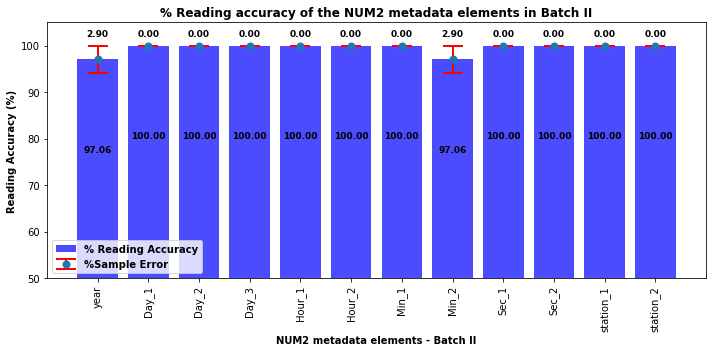

In [91]:
df_num2_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num2.csv") 
total_num2_II = len(df_num2_II)
print ('Number of Images Analyzed in BATCH II:', total_num2_II)
categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data_num2_II = []
for column in categorical_columns:
    col_sum = df_num2_II[column].sum()
    accuracy_percent = (col_sum/total_num2_II)*100
    p = accuracy_percent/100
    sample_error = np.sqrt(p*(1-p)/total_num2_II)*100
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: {accuracy_percent:.2f}%')
    print (f'Sample Error for "{column}" element: {sample_error:.2f}')
    
    accuracy_data_num2_II.append ((column, accuracy_percent,sample_error))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies, sample_error  = zip(*accuracy_data_num2_II) 
bar = plt.bar (categories, accuracies, color = 'blue', alpha = 0.7)
error_bar = plt.errorbar(categories, accuracies, yerr = sample_error,fmt= 'o', capsize = 10, ecolor = 'red', elinewidth = 2, markeredgewidth = 2)
plt.ylim(50, 105)

plt.title ("% Reading accuracy of the NUM2 metadata elements in Batch II", fontweight = 'bold')
plt.xlabel("NUM2 metadata elements - Batch II", fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)", fontweight = 'bold')
plt.xticks(rotation=90)

plt.yticks (np.arange(50, 105, step = 10))

#creating a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', '%Sample Error']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding numbers on top of the error bars and bars
for i, (bar_height, err_height) in enumerate (zip(accuracies, sample_error)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plt.text(i, bar_height -20 , f'{bar_height:.2f}', ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
    plt.text(i, bar_height + err_height +2 , f'{err_height:.2f}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.tight_layout()
plt.show()


### Total NUM2 Category

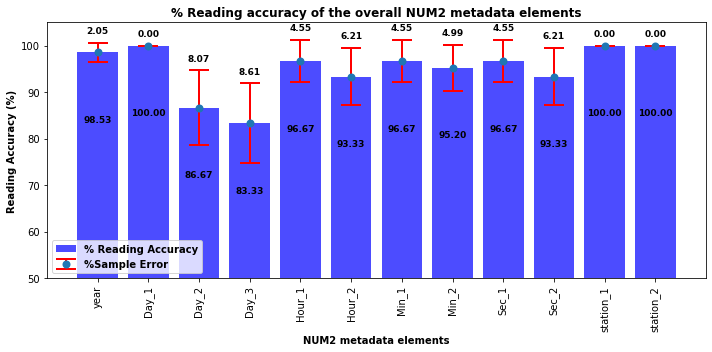

In [92]:
combined_accuracy_data_num2 = []
for i in range(len(categorical_columns)):
    column = categorical_columns [i]
    combined_accuracy =(accuracy_data_num2_I[i][1] + accuracy_data_num2_II[i][1])/2
    combined_sample_error = np.sqrt((accuracy_data_num2_I[i][2]**2 + accuracy_data_num2_II[i][2]**2)/2)
    combined_accuracy_data_num2.append((column, combined_accuracy, combined_sample_error))
    
#plotting the graph of batch I and II
fig = plt.figure (figsize= (10, 5))
categories, accuracies, sample_error = zip(*combined_accuracy_data_num2)
bar = plt.bar(categories, accuracies, color = 'blue', alpha = 0.7)
error_bar = plt.errorbar(categories, accuracies, yerr = sample_error, fmt="o", capsize = 10,
                        ecolor = 'red', elinewidth = 2, markeredgewidth = 2)

plt.ylim(50, 105)
plt.title ("% Reading accuracy of the overall NUM2 metadata elements", fontweight = 'bold')
plt.xlabel("NUM2 metadata elements",  fontweight = 'bold')
plt.ylabel("Reading Accuracy (%)",  fontweight = 'bold')
plt.xticks(rotation=90)
plt.yticks(np.arange(50, 105, step = 10))

#adding a legend
legend_handles = [bar[0], error_bar]
legend_labels = ['% Reading Accuracy', '%Sample Error']
plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

#adding numbers on top of the error bars and bars
for i, (bar_height, err_height) in enumerate (zip(accuracies, sample_error)):
    text_height = max(bar_height, bar_height+err_height)
    if text_height >100:
        text_height = 100
    plt.text(i, bar_height + -15 , f'{bar_height:.2f}', ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
    plt.text(i, bar_height + err_height+2, f'{err_height:.2f}',  ha = 'center', color = 'black', fontsize = 9, weight = 'bold')
plt.tight_layout()
plt.show()
             

## Dot category

In [16]:
df_dot_I = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_dot_I = df_dot_I[df_dot_I['processed_image_class']=='dot']
total_df_dot_I= len(filter_df_dot_I)
print ('Total number of dot Ionograms in BATCH I:', total_df_dot_I)

df_dot_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_dot_II = df_dot_II[df_dot_II['processed_image_class']=='dot']
total_df_dot_II = len(filter_df_dot_II)
print ('Total number of dot Ionograms in BATCH II:', total_df_dot_II)

Total_dot = total_df_dot_I + total_df_dot_II  #combining Batch I and Batch II num data
print ('Total dot ionograms in Batch I and II: ', Total_dot)

Total number of dot Ionograms in BATCH I: 7784
Total number of dot Ionograms in BATCH II: 4481
Total dot ionograms in Batch I and II:  12265


Number of dot Ionograms Analyzed: 10
Number of ionograms categorized correctly: 0
Estimated Success Rate out of 7784 with consistent results: 0


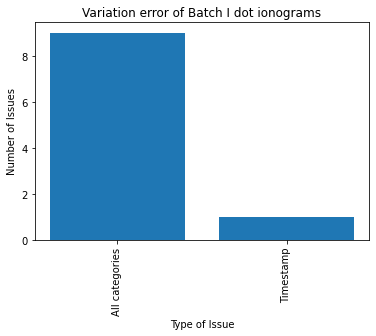

     Directory  Subdirectory       Filename
0  R014207940F           339  Image0150.png
1  R014207979F           394  Image0062.png
2  R014207929F           480  Image0242.png
3  R014207929F           476  Image0003.png
4  R014207907F           508      Image0119
6  R014207907F           512  Image0353.png
7  R014207979F           297  Image0206.png
8  R014207979F           291  Image0330.png
9  R014207940F           404  Image0224.png


In [17]:
#Batch I
df_dot_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_dot_QA.csv")
total_dot_I = len(df_dot_I)
print('Number of dot Ionograms Analyzed:', total_dot_I)

# filtering out correct categories
df_dot_I= df_dot_I.loc[df_dot_I['Issue'] != 'None']
filtered_down_dot_I = len(df_dot_I)
print('Number of ionograms categorized correctly:', total_dot_I - filtered_down_dot_I)

#Estimated success rate
success_rate = (total_dot_I - filtered_down_dot_I)/total_dot_I
Estimation = round(success_rate*total_df_dot_I)
print('Estimated Success Rate out of 7784 with consistent results:', Estimation)

#Plotting the variation of issues
issue_counts_dot_I = df_dot_I["Issue"].value_counts()
plt.bar(issue_counts_dot_I.index, issue_counts_dot_I.values)
plt.title ("Variation error of Batch I dot ionograms")
plt.xlabel("Type of Issue")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)
plt.show()

# Number of All categories error
df_dot_I = df_dot_I.loc[df_dot_I['Issue'] == 'All categories']
print(df_dot_I.loc[:,["Directory","Subdirectory", "Filename"]])


Number of Images Analyzed: 15
Number of Ionograms Analyzed correctly: 0
Estimated Success Rate out of 4481 with consistent results: 0.0


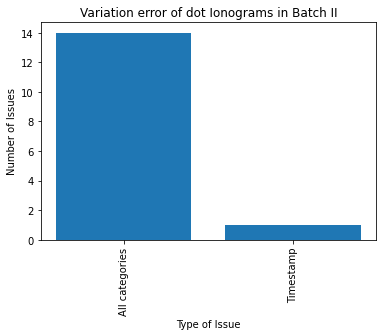

Number of NUM/NUM2 ionograms categorized as dot data by the algorithm: 14
     Directory Subdirectory filename
0   R014207961       1039-1  283.png
1   R014207961       1069-A  297.png
3   R014207944     1994-12A  131.png
4   R014207961       1076-A  288.png
5   R014207961       1039-1   19.png
6   R014207961       1069-A  263.png
7   R014207944      2042-3A  272.png
8   R014207961       1058-A  336.png
9   R014207961       1029-A  129.png
10  R014207961       1031-A  178.png
11  R014207944      2042-3A  125.png
12  R014207961       1031-A  154.png
13  R014207961       1076-A  158.png
14  R014207961       1065-A  231.png


In [18]:
#Batch II
df_dot_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_dot.csv")
total_dot_II = len(df_dot_II)
print ('Number of Images Analyzed:', total_dot_II)
filtered_down_dot_II = 0 #no ionogram was analyzed correctly
print('Number of Ionograms Analyzed correctly:',filtered_down_dot_II)

#Estimated success rate
success_rate = filtered_down_dot_II/total_dot_II
Estimation = success_rate*total_df_dot_II
print('Estimated Success Rate out of 4481 with consistent results:', Estimation)

#Plotting the variation of issues
issue_counts_dot_II = df_dot_II["Issue"].value_counts()
plt.bar(issue_counts_dot_II.index, issue_counts_dot_II.values)
plt.title ("Variation error of dot Ionograms in Batch II")
plt.xlabel("Type of Issue")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)
plt.show()

# filtering out correct categories
df_dot_II = df_dot_II.loc[df_dot_II['Issue'] == 'All categories']
filtered_down_dot_II = len(df_dot_II)
print('Number of NUM/NUM2 ionograms categorized as dot data by the algorithm:', filtered_down_dot_II)
print(df_dot_II.loc[:,["Directory","Subdirectory", "filename"]])

In [19]:
#Total Dot image analysis:
Image_total_dot = total_dot_I + total_dot_II
print ('Total number of DOT Ionograms in BATCH I and II analyzed:', Image_total_dot)

Correct_total_dot = (total_dot_I - filtered_down_dot_I) + (total_dot_II - filtered_down_dot_II)
print ('Total number of Dot Ionograms in BATCH II and II analyzed correctly: ', Correct_total_dot)

#Estimated success rate
Estimation  = round(Correct_total_dot*Image_total_dot/Total_dot)
print('Estimated Success Rate of Total Dot with 12,265 ionograms:', Estimation)

#Percent certaintly
percent_tot_dot = Estimation*100/Total_dot
print('Estimated Percent certainty:' , percent_tot_dot)

Total number of DOT Ionograms in BATCH I and II analyzed: 25
Total number of Dot Ionograms in BATCH II and II analyzed correctly:  1
Estimated Success Rate of Total Dot with 12,265 ionograms: 0
Estimated Percent certainty: 0.0


In [25]:
# BATCH II - Summary
df_num2_II = df_num2_II.loc[df_num2_II ['Issue'] != 'None']
filtered_down_num2_II = len(df_num2_II)
print ('Batch II Summary:')
print('Total number of Ionograms categorized correctly consistently:', total_num2_II - filtered_down_num2_II)

#BATCH II - Estimated success rate
success_rate = (total_num2_II - filtered_down_num2_II)/total_num2_II
Estimation = round(success_rate*total_df_num2)
print('Estimated Success Rate of BATCH II with 126,073 ionograms:', Estimation)
# Number of All categories error
df_num2_II = df_num2_II.loc[df_num2_II['Issue'] == 'Minute']
filtered_down_II = len(df_num2_II)
print('The algorithm reads 1 as 7 or vice versa:', filtered_down_II)
print(df_num2_II.loc[:,["Directory","Subdirectory", "filename"]])

Batch II Summary:
Total number of Ionograms categorized correctly consistently: 31
Estimated Success Rate of BATCH II with 126,073 ionograms: 114949
The algorithm reads 1 as 7 or vice versa: 2
    Directory Subdirectory filename
5  R014207831      3949-5A  207.png
8  R014207833      4349-38  136.png
